# IDS705 Machine Learning Final Project: X-ray Identification of COVID-19

### Loading packages

In [2]:
import tensorflow as tf

from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import AveragePooling2D, MaxPooling2D, Concatenate
from keras.layers.core import Flatten, Dense, Dropout
from keras import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


### Load Data

In [8]:
def load_data(dir_data, dir_labels, training=True):
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    i = 0
    for identifier in ids:
        if i%800 ==1:
            print(i, end = ' ')
        i+=1
        fname     = dir_data + identifier
        image     = cv2.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    pass

In [9]:
'''
set data dir
'''
dir_train_images  = './data/train_resize/'
dir_test_images   = './data/test_resize/'
dir_train_labels  = './train_labels.csv'
dir_test_labels   = './test_labels.csv'

In [10]:
"""
generate subset of training dataset indes from csv file

np.random.seed(19)
label = pd.read_csv("./train_split_v2.csv")
normal    = label.loc[label.label =="normal"].sample(n=700, random_state=19).copy()
pneumonia = label.loc[label.label =="pneumonia"].sample(n=700, random_state=19).copy()
label = label.loc[label.label =="COVID-19"]
label = label.append([normal, pneumonia], ignore_index = True)
label.to_csv("train_sub.csv")
"""

'\ngenerate subset of training dataset indes from csv file\n\nnp.random.seed(19)\nlabel = pd.read_csv("./train_split_v2.csv")\nnormal    = label.loc[label.label =="normal"].sample(n=700, random_state=19).copy()\npneumonia = label.loc[label.label =="pneumonia"].sample(n=700, random_state=19).copy()\nlabel = label.loc[label.label =="COVID-19"]\nlabel = label.append([normal, pneumonia], ignore_index = True)\nlabel.to_csv("train_sub.csv")\n'

#### Training and Validation Data Loading and Preprocessing

In [20]:
X_train, y_train = load_data(dir_train_images, dir_train_labels, training=True)

X_train = np.mean(X_train, axis=3)
X_train = X_train.astype(np.uint8)

X_train_rgb = []
for img in X_train:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_train_rgb.append(img_rgb)
X_train_rgb = np.array(X_train_rgb)
#X_train_rgb = X_train #used when disable cv2.color gray2rgb 
X_train_rgb = (X_train_rgb)/255

print('label categorization')
y_train[y_train=='normal']=0
y_train[y_train=='pneumonia']=1
y_train[y_train=='COVID-19']=2

y_train_cat = to_categorical(y_train, num_classes = 3)

'''
split the training dataset into train/validation set
'''
print('splitting training/val set')
from sklearn.model_selection import train_test_split
indxs = np.arange(0, 2625, 1)
X_training, X_val, y_training, y_val, idx_train, idx_val = train_test_split(X_train_rgb, y_train_cat, indxs, test_size=0.4, random_state=1428)

X_training = X_training.reshape(-1,224,224,3)
X_val = X_val.reshape(-1,224,224,3)

#training:class 0 = 5576; class 1 = 5968; class 2 = 73
#test:class 0 = 2390; class 1 = 2558; class 2 = 32
#

1 801 1601 2401 label categorization
splitting training/val set


#### Test Data Loading and Preprocessing

In [12]:
X_test, y_test = load_data(dir_test_images, dir_test_labels, training=True)
X_test = np.mean(X_test, axis=3)
X_test = X_test.astype(np.uint8)
X_test_rgb = []
for img in X_test:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_test_rgb.append(img_rgb)
X_test_rgb = np.array(X_test_rgb)

X_test_rgb = (X_test_rgb)/255

y_test[y_test=='normal']=0
y_test[y_test=='pneumonia']=1
y_test[y_test=='COVID-19']=2
y_test_cat = to_categorical(y_test, num_classes = 3)

1 

### Pretrained Model: ResNet50

In [78]:
### VGG ###

# vgg_pretrained_model = VGG16(weights="imagenet", 
#                              include_top= False,
#                              input_tensor=Input(shape=(224, 224, 3)))
# new_model = vgg_pretrained_model.output

### ResNet50 ###

resnet50_pretrained = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

new_model = resnet50_pretrained.output
new_model = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(new_model)
new_model = Dropout(0.4)(new_model)#4/8 add droup here
new_model = Flatten(name="flatten")(new_model)
#new_model = Dense(12, activation="relu")(new_model)
#new_model = Dropout(0.3)(new_model)
new_model = Dense(3, activation="softmax")(new_model)    

# model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)
model = Model(inputs=resnet50_pretrained.input, outputs=new_model)

### Data Augmentation

In [79]:
BS = 6
EPOCHS = 100

opt = Adam(lr=0.0001, decay=0.01 / (EPOCHS))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

class_weight = {0: 0.1,
                1: 0.1,
                2: 11.}

aug = ImageDataGenerator(ImageDataGenerator(rotation_range=10., width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                         horizontal_flip=True,vertical_flip =True,  fill_mode="nearest"))

### Fitting Model

In [80]:
np.random.seed(28)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
H = model.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                        validation_data=(X_val, y_val), steps_per_epoch=len(X_training) // BS, epochs=EPOCHS, verbose=1,
                        class_weight = class_weight, callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

C:\programming\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
C:\programming\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
175/175 [==============================] - 35s 198ms/step - loss: 0.4861 - accuracy: 0.4928 - val_loss: 6.2612 - val_accuracy: 0.4580
Epoch 2/100
175/175 [==============================] - 25s 142ms/step - loss: 0.3223 - accuracy: 0.6925 - val_loss: 1.1338 - val_accuracy: 0.5863
Epoch 3/100
175/175 [==============================] - 25s 141ms/step - loss: 0.2735 - accuracy: 0.7431 - val_loss: 2.8222 - val_accuracy: 0.5575
Epoch 4/100
175/175 [==============================] - 25s 144ms/step - loss: 0.1535 - accuracy: 0.7278 - val_loss: 1.9554 - val_accuracy: 0.4867
Epoch 5/100
175/175 [==============================] - 25s 142ms/step - loss: 0.3064 - accuracy: 0.7030 - val_loss: 2.3978 - val_accuracy: 0.3783
Epoch 6/100
175/175 [==============================] - 25s 142ms/step - loss: 0.3314 - accuracy: 0.7096 - val_loss: 1.3211 - val_accuracy: 0.5465
Epoch 7/100
175/175 [==============================] - 25s 142ms/step - loss: 0.1477 - accuracy: 0.6934 - val_loss: 0.8448 -

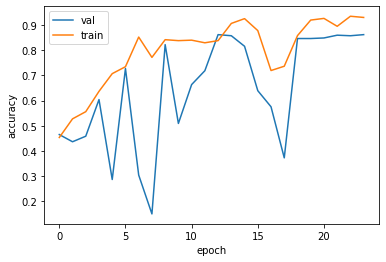

In [72]:
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

### Checking Predictions and Performance

In [73]:
'''
Validation
'''
score = model.predict(np.array(X_val))

y_preds = np.argmax(score, axis=1)
ytest = np.argmax(y_val, axis=1)
print(accuracy_score(ytest, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.8628318584070797


Predicted,0,1,2,All
True,,,,
0,186,16,7,209
1,28,170,9,207
2,0,2,34,36
All,214,188,50,452


In [74]:
'''
Train
'''
score = model.predict(np.array(X_train_rgb))

y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_train.astype(int), y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9262458471760797


Predicted,0,1,2,All
True,,,,
0,661,30,9,700
1,57,630,13,700
2,0,2,103,105
All,718,662,125,1505


In [ ]:
'''
Save predictions if good performance
'''

# score = model.predict(X_train_rgb)
# np.savetxt("./scores/resnet50_scores.csv", score, delimiter=",")

# y_preds = np.argmax(score, axis=1)

# accuracy_score(y_train.ravel(), y_preds)
# confusion_matrix(y_train.ravel(), y_preds)

# pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

### Load Model

In [33]:
filename = 'resnet50_92.sav'
history = "hist_resnet50.sav"

In [34]:
'''
load model and training history
'''
loaded_model = pickle.load(open(filename, 'rb'))
H = pickle.load(open(history, 'rb'))

### Plot training history

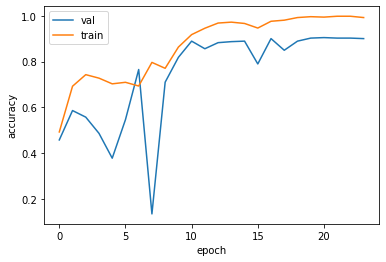

In [9]:
# training history
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

### Analyze Performance

In [19]:
# Train
y_probs_train = loaded_model.predict(np.array(X_train_rgb))
y_preds_train = np.argmax(y_probs_train, axis=1)

In [20]:
# Validation
y_val = np.argmax(y_val, axis = 1)
y_probs_val = loaded_model.predict(np.array(X_val))
y_preds_val = np.argmax(y_probs_val, axis=1)

In [21]:
# Test
y_probs_test = loaded_model.predict(np.array(X_test_rgb))
y_preds_test = np.argmax(y_probs_test, axis=1)

In [22]:
np.savetxt('y_probs_train.csv', y_probs_train, delimiter = ',')
np.savetxt('y_probs_val.csv', y_probs_val, delimiter = ',')
np.savetxt('y_probs_test.csv', y_probs_test, delimiter = ',')

In [36]:
def plot_cm(ytrue, ypred, title):
    cm = confusion_matrix(ytrue, ypred) 

    cm_df = pd.DataFrame(cm,
                         index = ['normal','pneumonia','COVID-19'], 
                         columns = ['normal','pneumonia','COVID-19'])

    cm_plot = plt.figure(figsize=(8,8))
    sns.heatmap(cm_df, annot=True, annot_kws={"size": 14}, cmap = 'Blues', fmt='g')
    plt.title('Confusion Matrix {0} Data \nAccuracy:{1:.3f}'.format(title, accuracy_score(ytrue, ypred)), fontsize = 18)
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

### Train

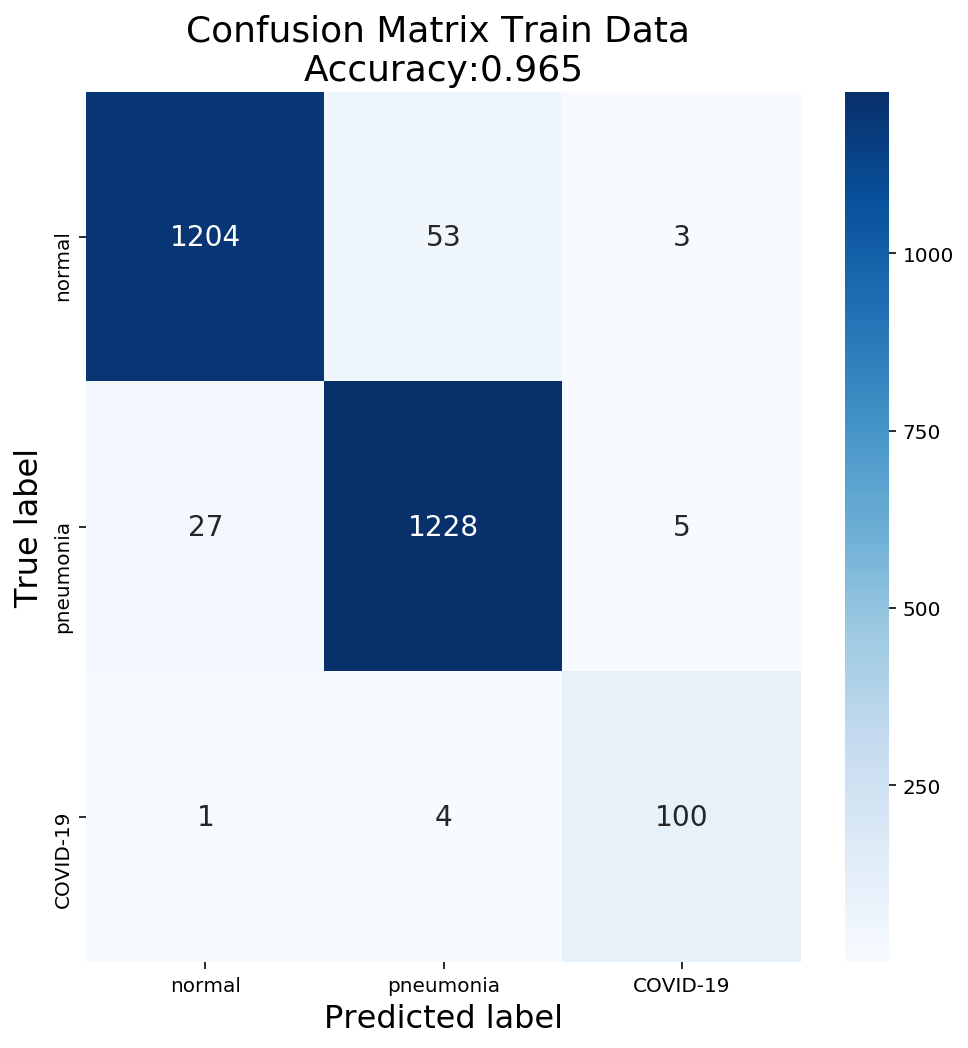

In [23]:
y_train = y_train.astype(int)
plot_cm(y_train, y_preds_train, 'Train')

### Validation

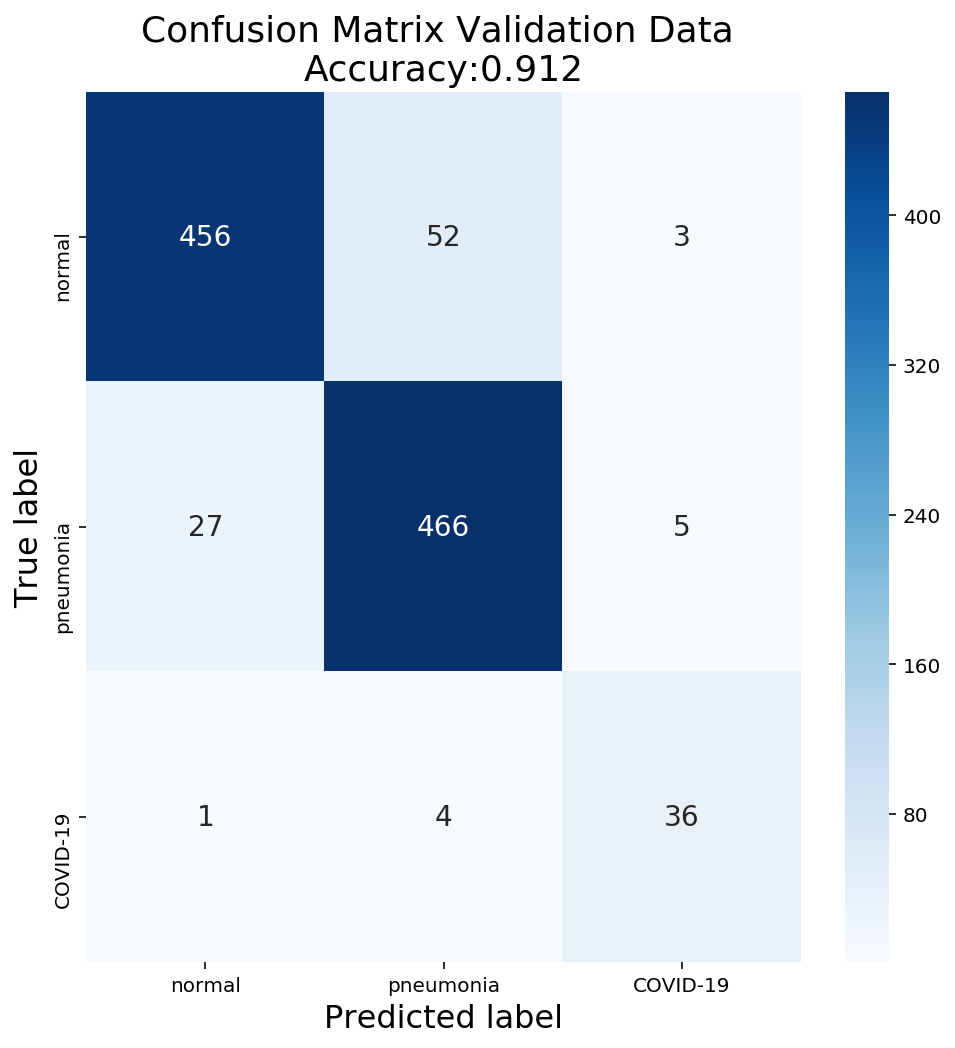

In [24]:
plot_cm(y_val, y_preds_val, 'Validation')

### Test

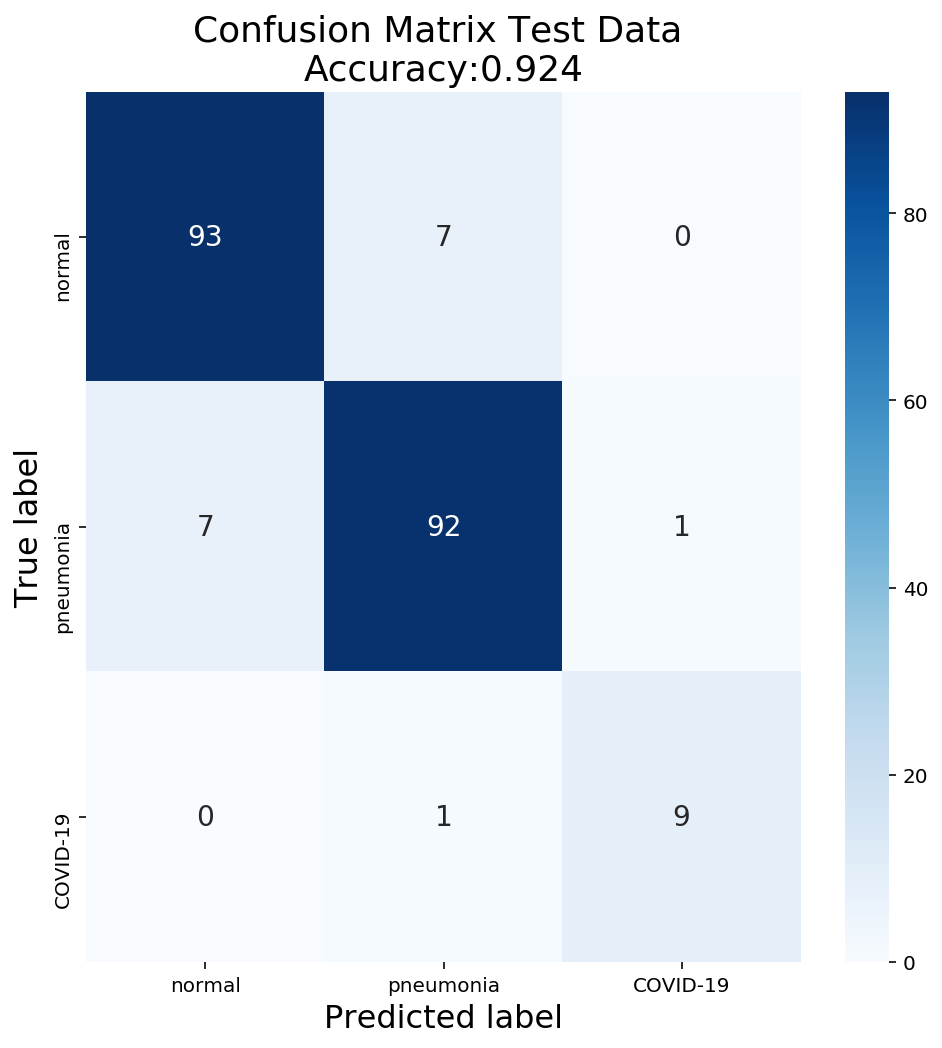

In [25]:
y_test = y_test.astype(int)
plot_cm(y_test, y_preds_test, 'Test')

In [26]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, y_preds_test, average = 'weighted'))
print(recall_score(y_test, y_preds_test, average = 'weighted'))
print(accuracy_score(y_test, y_preds_test))

0.9238095238095239
0.9238095238095239
0.9238095238095239


### Data Distribution

In [21]:
train.shape

(2625, 3)

In [19]:
train.groupby('label').size()

label
COVID-19      105
normal       1260
pneumonia    1260
dtype: int64

In [22]:
test.shape

(1953, 2)

In [20]:
test.groupby('label').size()

label
COVID-19       10
normal        885
pneumonia    1058
dtype: int64

### SVM

In [27]:
from sklearn.svm import SVC 

svm = SVC(gamma = 'scale', C = 10).fit(X_train.reshape(X_train.shape[0], -1), y_train) 

In [ ]:
svm_train = svm.predict(X_train.reshape(X_train.shape[0], -1))

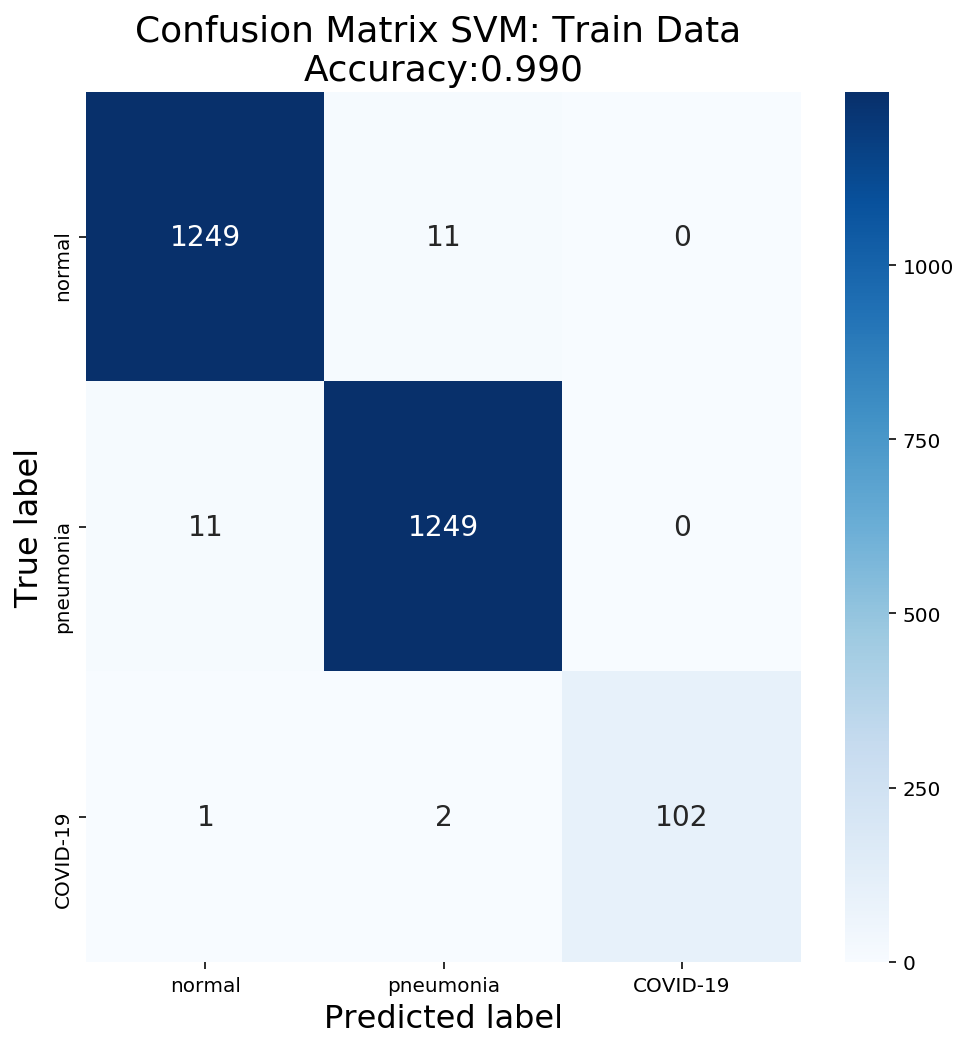

In [33]:
plot_cm(y_train, svm_train, 'SVM: Train')

In [32]:
# svm_val = svm.predict(X_val.reshape(X_val.shape[0], -1))
# plot_cm(y_val, svm_val, 'Validation')

In [ ]:
svm_test = svm.predict(X_test.reshape(X_test.shape[0], -1))

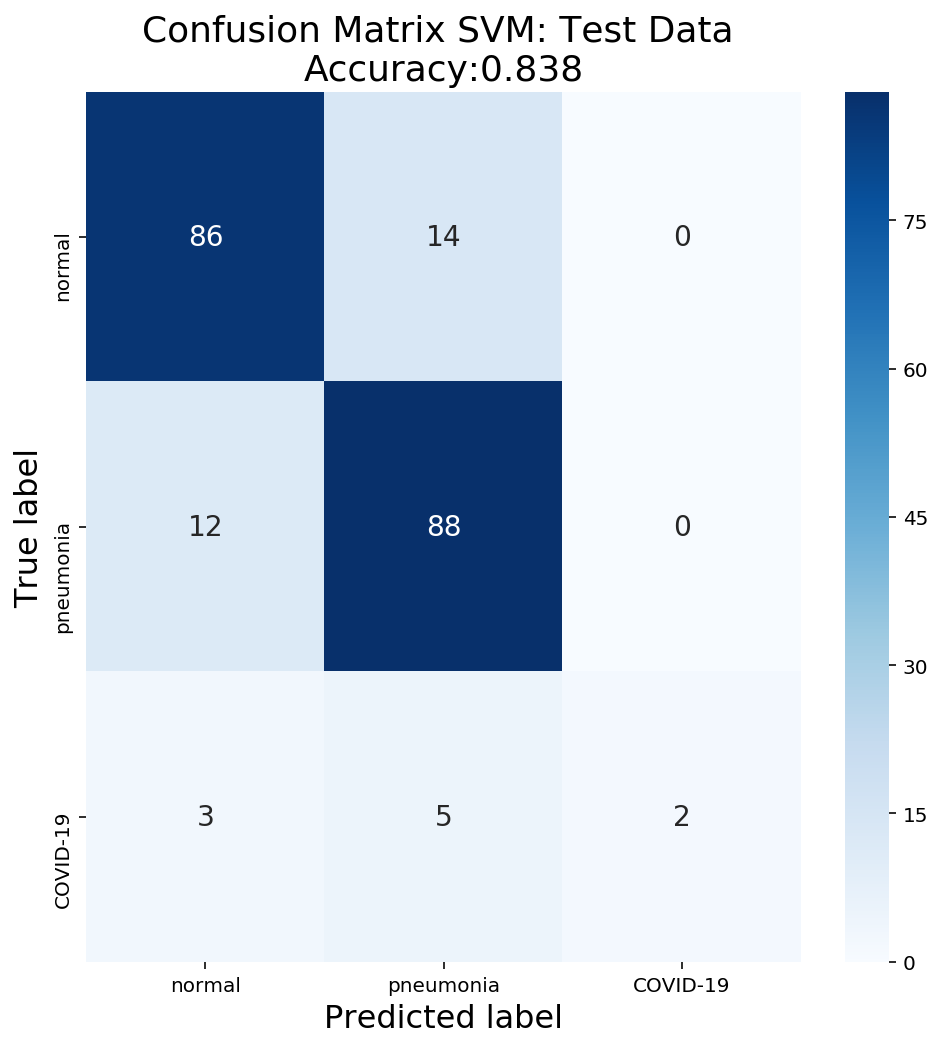

In [31]:
plot_cm(y_test, svm_test, 'SVM: Test')

### Random Guess

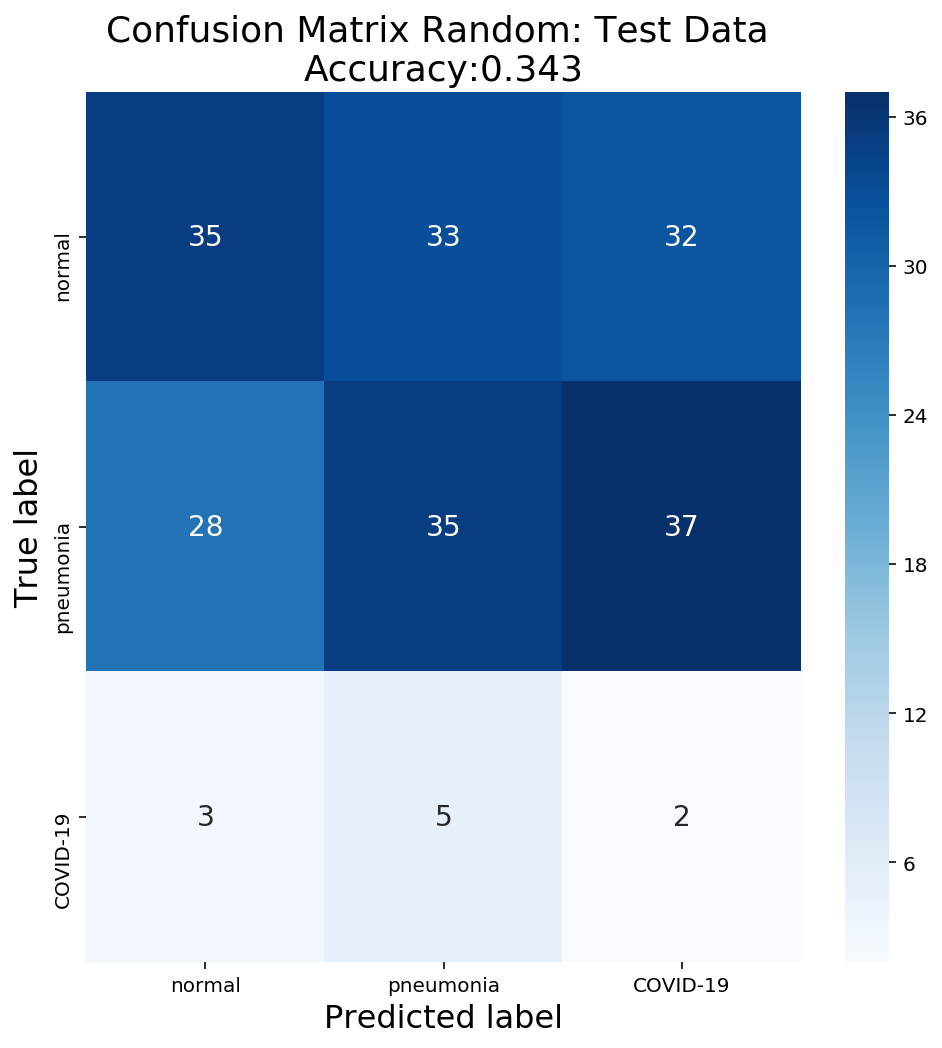

In [32]:
rand = np.random.randint(0,3, size = y_test.shape[0])
plot_cm(y_test, rand, 'Random: Test')

### Misclassifications

In [15]:
y_probs_train = pd.read_csv('y_probs_train.csv', header = None)
y_probs_val = pd.read_csv('y_probs_val.csv', header = None)
y_probs_test = pd.read_csv('y_probs_test.csv', header = None)

In [28]:
y_preds_train = np.argmax(np.array(y_probs_train), axis=1)

In [23]:
y_preds_train = y_probs_train.idxmax(axis=1)
tp = pd.DataFrame(idx_val[(y_train == 0) & (y_preds_train.T == 0)])
tp = tp.sort_values(by = 0).values.ravel()
# pd.Series(cnn_scores)[tp].dropna().sort_values()

2625

In [ ]:
tp_cnn = pd.DataFrame(idx_val[(y_val == 1) & (cnn_preds.T == 1)])
tp_cnn = tp_cnn.sort_values(by = 0).values.ravel()
pd.Series(cnn_scores)[tp_cnn].dropna().sort_values()

### Model Summary 

In [14]:
loaded_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________